In [3]:
import tensorflow as tf
import numpy as np
import gzip
import keras
import matplotlib.pyplot as plt
import time
import random
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

Using TensorFlow backend.


Get MNIST

In [9]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

# read data set
f = gzip.open('./data/train-images-idx3-ubyte.gz', 'rb')
x_train = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb')
y_train = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

f = gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb')
x_test = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb')
y_test = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

# data preprocessing
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_train = x_train.astype(np.float32)
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_test = x_test.astype(np.float32)

# get each training images
idx_train = [0 for i in range(10)]
idx_test = [0 for i in range(10)]
for i in range(10):
    idx_train[i] = (y_train == i)
    idx_test[i] = (y_test == i)
      
x_train_38 = x_train[idx_train[3]+idx_train[8]]
x_test_38 = x_test[idx_test[3]+idx_test[8]]  

# y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
# print(np.count_nonzero(y_train_38[y_train_38==3]))

# one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


y_train_38 = y_train[idx_train[3]+idx_train[8]]
y_test_38 = y_test[idx_test[3]+idx_test[8]] 



In [11]:
# K-Means clustering to find centers
start = time.time()
kmeans_model = KMeans(2)
kmeans_model.fit(x_train[idx_train[8]+idx_train[3]])
_38=np.reshape(kmeans_model.cluster_centers_,(-1,784))
print("Cluster Production time(sec) :", time.time() - start)
# x_model = KMeans(100)
# x_model.fit(x_train)
# x = x_model.predict(x_model.cluster_centers_)
# x = keras.utils.to_categorical(x,100)

x = np.zeros((2,2))
for i in range(2):
    x[i][i] = 1

Cluster Production time(sec) : 4.310314893722534


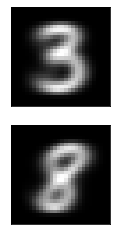

In [12]:
fig = plt.figure()

for i in range(2):
  subplot = fig.add_subplot(2,1, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(np.reshape(_38[i], (28, 28)), cmap='gray')

In [14]:
row = [random.randrange(0,22) for i in range(50)]
col = [random.randrange(0,22) for i in range(50)]
train_label=[]
train_image =[]
test_image=[]
test_label=[]

centers =[]

for i in range(50):
    for cluster in _38:
        centers.extend(cluster[r*28+col[i] : r*28+(col[i]+7) ] for r in range(row[i],row[i]+7))
centers = np.reshape(centers,(-1,49))

for j in range(50):
    for i in range(len(x_train_38)):
        train_image.extend(x_train_38[i][r*28+col[j] : r*28+(col[j]+7) ] for r in range(row[j],row[j]+7))
        train_label.extend(y_train_38[i])
train_image = np.reshape(train_image,(-1,49))
train_label = np.reshape(train_label,(-1,10))
print(train_image.shape)

for j in range(50):
    for i in range(len(x_test_38)):
        test_image.extend(x_test_38[i][r*28+col[j] : r*28+(col[j]+7) ] for r in range(row[j],row[j]+7))
        test_label.extend(y_test_38[i])    
test_image = np.reshape(test_image,(-1,49))
test_label = np.reshape(test_label,(-1,10))
                                                                                                                                                                                                                                            
# train_random = np.arange(train_image.shape[0])
# np.random.shuffle(train_random)
# test_random = np.arange(test_image.shape[0])
# np.random.shuffle(test_random)

# train_image = train_image[train_random]
# train_label = train_label[train_random]
# test_image = test_image[test_random]
# test_label = test_label[test_random]


(599100, 49)


In [8]:
# # plot cluster centers as images
# imgs = centers * 255
# fig = plt.figure(figsize =(5,100))
# for i in range(50):
#   subplot = fig.add_subplot(50,2, 2*i+1)
#   subplot.imshow(np.reshape(centers[i], (7, 7)), cmap='gray')
#   subplot = fig.add_subplot(50,2, 2*i+2)
#   subplot.imshow(np.reshape(centers[i+50], (7, 7)), cmap='gray')
  
# plt.savefig('rbf_centers.png')


In [17]:

class Model:
    
    def __init__(self, m_train_image, m_test_image, m_train_label , m_test_label):
        self.m_train_image = m_train_image
        self.m_test_image = m_test_image
        self.m_train_label = m_train_label
        self.m_test_label = m_test_label
        self.temp1 = None
        self.temp2 = None
        self.model = None
        self.predict_value =[]
        
    
    def _RBF(self, m_centers, m_x, segment):
        # RBF Layer
        kernel = PairwiseKernel(metric='polynomial') 
        rbf_model = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(m_centers[2*segment:2*(segment+1)], m_x)

        self.temp1 = rbf_model.predict(self.m_train_image)
        self.temp2 = rbf_model.predict(self.m_test_image)


    def _Perceptron(self):
        # Perceptron Layers
        batch_size = 128
        epochs = 100

        self.model = Sequential()
        self.model.add(Dense(10, activation='softmax', input_shape=(2,)))

        self.model.summary()
        nadam=keras.optimizers.Nadam(lr=0.0005)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=nadam,
                      metrics=['accuracy'])


        # Train model
        history = self.model.fit(self.temp1, self.m_train_label,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)
    def _Predict(self):
        predictions = self.model.predict(self.temp2)

        return predictions

In [20]:
models = []
for m in range(50):
    models.append(Model(train_image[m*len(x_train_38):(m+1)*len(x_train_38)],
                        test_image[m*len(x_test_38):(m+1)*len(x_test_38)],
                        train_label[m*len(y_train_38):(m+1)*len(y_train_38)],
                        test_label[m*len(y_test_38):(m+1)*len(y_test_38)]))

In [22]:
cnt = 0
softmax_sum = np.ones((len(x_test_38),10))
for m in models:
    m._RBF(centers, x, cnt)
    m._Perceptron()
    softmax_sum += m._Predict()
    cnt +=1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11982/11982 [==============================] - 0s 27us/step - loss: 3.1079 - acc: 0.3966
Epoch 2/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.8791 - acc: 0.4193
Epoch 3/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.6428 - acc: 0.4326
Epoch 4/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.4067 - acc: 0.4431
Epoch 5/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.1798 - acc: 0.4508
Epoch 6/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.9672 - acc: 0.4668
Epoch 7/100
11982/11982 [==============================] - 0s 15us/s

11982/11982 [==============================] - 0s 15us/step - loss: 0.6758 - acc: 0.6374
Epoch 77/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6747 - acc: 0.6372
Epoch 78/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6736 - acc: 0.6369
Epoch 79/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6726 - acc: 0.6371
Epoch 80/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6716 - acc: 0.6368
Epoch 81/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6707 - acc: 0.6363
Epoch 82/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6698 - acc: 0.6362
Epoch 83/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6689 - acc: 0.6365
Epoch 84/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6680 - acc: 0.6364
Epoch 85/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6672 - acc: 

11982/11982 [==============================] - 0s 14us/step - loss: 0.6177 - acc: 0.7087
Epoch 53/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6154 - acc: 0.7090
Epoch 54/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6132 - acc: 0.7080
Epoch 55/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6111 - acc: 0.7081
Epoch 56/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6092 - acc: 0.7083
Epoch 57/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6073 - acc: 0.7079
Epoch 58/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6055 - acc: 0.7081
Epoch 59/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6038 - acc: 0.7080
Epoch 60/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6022 - acc: 0.7081
Epoch 61/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6007 - acc: 

11982/11982 [==============================] - 0s 14us/step - loss: 0.9233 - acc: 0.6587
Epoch 29/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.9079 - acc: 0.6609
Epoch 30/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8935 - acc: 0.6615
Epoch 31/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8801 - acc: 0.6632
Epoch 32/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8676 - acc: 0.6635
Epoch 33/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8559 - acc: 0.6644
Epoch 34/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8449 - acc: 0.6636
Epoch 35/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8346 - acc: 0.6650
Epoch 36/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8249 - acc: 0.6657
Epoch 37/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8158 - acc: 

11982/11982 [==============================] - 0s 13us/step - loss: 2.7514 - acc: 0.0000e+00
Epoch 4/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.5461 - acc: 0.0000e+00
Epoch 5/100
11982/11982 [==============================] - 0s 14us/step - loss: 2.3515 - acc: 0.0010
Epoch 6/100
11982/11982 [==============================] - 0s 14us/step - loss: 2.1740 - acc: 0.2798
Epoch 7/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.0222 - acc: 0.4446
Epoch 8/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.8983 - acc: 0.5479
Epoch 9/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.7947 - acc: 0.5757
Epoch 10/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.7029 - acc: 0.5822
Epoch 11/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.6193 - acc: 0.5815
Epoch 12/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.5425 - acc

11982/11982 [==============================] - 0s 14us/step - loss: 0.6695 - acc: 0.5923
Epoch 84/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6688 - acc: 0.5929
Epoch 85/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6682 - acc: 0.5921
Epoch 86/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6675 - acc: 0.5929
Epoch 87/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6669 - acc: 0.5928
Epoch 88/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6663 - acc: 0.5925
Epoch 89/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6658 - acc: 0.5916
Epoch 90/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6652 - acc: 0.5931
Epoch 91/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6647 - acc: 0.5926
Epoch 92/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6642 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.6105 - acc: 0.7457
Epoch 60/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6084 - acc: 0.7455
Epoch 61/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6063 - acc: 0.7450
Epoch 62/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6044 - acc: 0.7449
Epoch 63/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6026 - acc: 0.7449
Epoch 64/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6009 - acc: 0.7448
Epoch 65/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5992 - acc: 0.7444
Epoch 66/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5976 - acc: 0.7448
Epoch 67/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5961 - acc: 0.7450
Epoch 68/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5947 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.8171 - acc: 0.5884
Epoch 36/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8097 - acc: 0.5888
Epoch 37/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8026 - acc: 0.5899
Epoch 38/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7960 - acc: 0.5902
Epoch 39/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7897 - acc: 0.5914
Epoch 40/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7839 - acc: 0.5931
Epoch 41/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7783 - acc: 0.5948
Epoch 42/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7731 - acc: 0.5974
Epoch 43/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7681 - acc: 0.6003
Epoch 44/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7634 - acc: 

Epoch 11/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.5511 - acc: 0.6072
Epoch 12/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.4813 - acc: 0.6126
Epoch 13/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.4234 - acc: 0.6154
Epoch 14/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.3727 - acc: 0.6172
Epoch 15/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.3271 - acc: 0.6183
Epoch 16/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.2853 - acc: 0.6204
Epoch 17/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.2468 - acc: 0.6213
Epoch 18/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.2110 - acc: 0.6218
Epoch 19/100
11982/11982 [==============================] - 0s 13us/step - loss: 1.1777 - acc: 0.6228
Epoch 20/100
11982/11982 [==============================] - 0s 14us/step - loss: 1

11982/11982 [==============================] - 0s 15us/step - loss: 0.6809 - acc: 0.6173
Epoch 92/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6802 - acc: 0.6158
Epoch 93/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6796 - acc: 0.6165
Epoch 94/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6791 - acc: 0.6172
Epoch 95/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6785 - acc: 0.6162
Epoch 96/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6780 - acc: 0.6167
Epoch 97/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6774 - acc: 0.6161
Epoch 98/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6770 - acc: 0.6158
Epoch 99/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6765 - acc: 0.6174
Epoch 100/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6760 - acc:

11982/11982 [==============================] - 0s 15us/step - loss: 0.7064 - acc: 0.5619
Epoch 68/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7052 - acc: 0.5628
Epoch 69/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7041 - acc: 0.5621
Epoch 70/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7030 - acc: 0.5614
Epoch 71/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7020 - acc: 0.5623
Epoch 72/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7010 - acc: 0.5619
Epoch 73/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7001 - acc: 0.5613
Epoch 74/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6992 - acc: 0.5618
Epoch 75/100
11982/11982 [==============================] - 0s 13us/step - loss: 0.6983 - acc: 0.5628
Epoch 76/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6975 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7814 - acc: 0.5396
Epoch 44/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7767 - acc: 0.5398
Epoch 45/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7724 - acc: 0.5409
Epoch 46/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7683 - acc: 0.5408
Epoch 47/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7644 - acc: 0.5425
Epoch 48/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7608 - acc: 0.5439
Epoch 49/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7573 - acc: 0.5448
Epoch 50/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7541 - acc: 0.5447
Epoch 51/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7510 - acc: 0.5449
Epoch 52/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7480 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.9618 - acc: 0.7166
Epoch 20/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.9378 - acc: 0.7184
Epoch 21/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9159 - acc: 0.7200
Epoch 22/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8960 - acc: 0.7210
Epoch 23/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8778 - acc: 0.7215
Epoch 24/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8612 - acc: 0.7231
Epoch 25/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8459 - acc: 0.7233
Epoch 26/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8318 - acc: 0.7222
Epoch 27/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8189 - acc: 0.7222
Epoch 28/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8068 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.6166 - acc: 0.6998
Epoch 100/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6162 - acc: 0.6989
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11982/11982 [==============================] - 0s 35us/step - loss: 2.9917 - acc: 0.1871
Epoch 2/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.7712 - acc: 0.2767
Epoch 3/100
11982/11982 [==============================] - 0s 14us/step - loss: 2.5618 - acc: 0.2985
Epoch 4/100
11982/11982 [==============================] - 0s 16us/step - loss: 2.3647 - acc: 0.3236
Epoch 5/100
11982/11982 [==============================] - 0s 15us/step - loss

11982/11982 [==============================] - 0s 15us/step - loss: 0.6717 - acc: 0.6480
Epoch 76/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6705 - acc: 0.6486
Epoch 77/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6695 - acc: 0.6482
Epoch 78/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6683 - acc: 0.6494
Epoch 79/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6674 - acc: 0.6494
Epoch 80/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6664 - acc: 0.6492
Epoch 81/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6653 - acc: 0.6505
Epoch 82/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6644 - acc: 0.6510
Epoch 83/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6635 - acc: 0.6505
Epoch 84/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6627 - acc: 

11982/11982 [==============================] - 0s 14us/step - loss: 0.5167 - acc: 0.8227
Epoch 52/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5132 - acc: 0.8230
Epoch 53/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5100 - acc: 0.8228
Epoch 54/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5070 - acc: 0.8232
Epoch 55/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5040 - acc: 0.8235
Epoch 56/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5012 - acc: 0.8231
Epoch 57/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4986 - acc: 0.8228
Epoch 58/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4961 - acc: 0.8228
Epoch 59/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4937 - acc: 0.8227
Epoch 60/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4914 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7473 - acc: 0.7575
Epoch 27/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7374 - acc: 0.7570
Epoch 28/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7281 - acc: 0.7566
Epoch 29/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7195 - acc: 0.7566
Epoch 30/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7114 - acc: 0.7554
Epoch 31/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7039 - acc: 0.7554
Epoch 32/100
11982/11982 [==============================] - 0s 13us/step - loss: 0.6967 - acc: 0.7556
Epoch 33/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6901 - acc: 0.7547
Epoch 34/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6838 - acc: 0.7541
Epoch 35/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6779 - acc: 

Epoch 2/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.1846 - acc: 0.4246
Epoch 3/100
11982/11982 [==============================] - 0s 14us/step - loss: 2.0229 - acc: 0.4775
Epoch 4/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.8713 - acc: 0.5262
Epoch 5/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.7306 - acc: 0.5924
Epoch 6/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.6015 - acc: 0.6920
Epoch 7/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.4848 - acc: 0.8030
Epoch 8/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.3806 - acc: 0.8597
Epoch 9/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.2887 - acc: 0.8664
Epoch 10/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.2083 - acc: 0.8665
Epoch 11/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1383 - 

11982/11982 [==============================] - 0s 15us/step - loss: 0.4683 - acc: 0.8402
Epoch 83/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4677 - acc: 0.8398
Epoch 84/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4671 - acc: 0.8394
Epoch 85/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4664 - acc: 0.8398
Epoch 86/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4659 - acc: 0.8400
Epoch 87/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4653 - acc: 0.8392
Epoch 88/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4648 - acc: 0.8393
Epoch 89/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4642 - acc: 0.8392
Epoch 90/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4638 - acc: 0.8393
Epoch 91/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4633 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7203 - acc: 0.6024
Epoch 59/100
11982/11982 [==============================] - 0s 13us/step - loss: 0.7182 - acc: 0.6032
Epoch 60/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7162 - acc: 0.6034
Epoch 61/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7143 - acc: 0.6023
Epoch 62/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7125 - acc: 0.6013
Epoch 63/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7108 - acc: 0.6022
Epoch 64/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7091 - acc: 0.6015
Epoch 65/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7076 - acc: 0.6011
Epoch 66/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7061 - acc: 0.6004
Epoch 67/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7047 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.6831 - acc: 0.7572
Epoch 35/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6759 - acc: 0.7571
Epoch 36/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6693 - acc: 0.7577
Epoch 37/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6630 - acc: 0.7583
Epoch 38/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6571 - acc: 0.7581
Epoch 39/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6515 - acc: 0.7581
Epoch 40/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6463 - acc: 0.7577
Epoch 41/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6414 - acc: 0.7576
Epoch 42/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6367 - acc: 0.7580
Epoch 43/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6323 - acc: 

11982/11982 [==============================] - 0s 13us/step - loss: 1.2632 - acc: 0.7431
Epoch 11/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.2061 - acc: 0.7423
Epoch 12/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1556 - acc: 0.7426
Epoch 13/100
11982/11982 [==============================] - 0s 13us/step - loss: 1.1109 - acc: 0.7419
Epoch 14/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.0710 - acc: 0.7411
Epoch 15/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.0352 - acc: 0.7409
Epoch 16/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.0031 - acc: 0.7403
Epoch 17/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.9741 - acc: 0.7402
Epoch 18/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9477 - acc: 0.7400
Epoch 19/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9238 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.5974 - acc: 0.7293
Epoch 91/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5970 - acc: 0.7297
Epoch 92/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5965 - acc: 0.7293
Epoch 93/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5961 - acc: 0.7293
Epoch 94/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5957 - acc: 0.7298
Epoch 95/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5953 - acc: 0.7296
Epoch 96/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5949 - acc: 0.7293
Epoch 97/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5945 - acc: 0.7298
Epoch 98/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5941 - acc: 0.7297
Epoch 99/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5938 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.6705 - acc: 0.6408
Epoch 67/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6692 - acc: 0.6413
Epoch 68/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6680 - acc: 0.6413
Epoch 69/100
11982/11982 [==============================] - 0s 13us/step - loss: 0.6669 - acc: 0.6416
Epoch 70/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6657 - acc: 0.6414
Epoch 71/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6647 - acc: 0.6415
Epoch 72/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6637 - acc: 0.6420
Epoch 73/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6627 - acc: 0.6410
Epoch 74/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6618 - acc: 0.6417
Epoch 75/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6609 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7290 - acc: 0.7066
Epoch 43/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7234 - acc: 0.7056
Epoch 44/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7181 - acc: 0.7053
Epoch 45/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7130 - acc: 0.7037
Epoch 46/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7082 - acc: 0.7040
Epoch 47/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7037 - acc: 0.7029
Epoch 48/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6994 - acc: 0.7029
Epoch 49/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6953 - acc: 0.7010
Epoch 50/100
11982/11982 [==============================] - 0s 13us/step - loss: 0.6915 - acc: 0.7010
Epoch 51/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6878 - acc: 

11982/11982 [==============================] - 0s 16us/step - loss: 0.8890 - acc: 0.8818
Epoch 19/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8523 - acc: 0.8816
Epoch 20/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8201 - acc: 0.8812
Epoch 21/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7916 - acc: 0.8812
Epoch 22/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7660 - acc: 0.8818
Epoch 23/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7428 - acc: 0.8821
Epoch 24/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7216 - acc: 0.8819
Epoch 25/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7022 - acc: 0.8820
Epoch 26/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6843 - acc: 0.8822
Epoch 27/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6676 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.3686 - acc: 0.8709
Epoch 99/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.3681 - acc: 0.8709
Epoch 100/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.3677 - acc: 0.8705
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11982/11982 [==============================] - 1s 49us/step - loss: 2.3157 - acc: 0.4364
Epoch 2/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.1347 - acc: 0.4704
Epoch 3/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.9686 - acc: 0.4922
Epoch 4/100
11982/11982 [==============================] - 0s 15us/step - los

11982/11982 [==============================] - 0s 15us/step - loss: 0.4058 - acc: 0.8743
Epoch 75/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4048 - acc: 0.8739
Epoch 76/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4038 - acc: 0.8738
Epoch 77/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4028 - acc: 0.8732
Epoch 78/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4019 - acc: 0.8734
Epoch 79/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4011 - acc: 0.8722
Epoch 80/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4002 - acc: 0.8721
Epoch 81/100
11982/11982 [==============================] - 0s 13us/step - loss: 0.3994 - acc: 0.8723
Epoch 82/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3987 - acc: 0.8721
Epoch 83/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.3980 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7377 - acc: 0.5117
Epoch 50/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7354 - acc: 0.5117
Epoch 51/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7332 - acc: 0.5117
Epoch 52/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7311 - acc: 0.5117
Epoch 53/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7291 - acc: 0.5117
Epoch 54/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7273 - acc: 0.5117
Epoch 55/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7255 - acc: 0.5117
Epoch 56/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7239 - acc: 0.5134
Epoch 57/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7223 - acc: 0.5184
Epoch 58/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7208 - acc: 

11982/11982 [==============================] - 0s 16us/step - loss: 0.8290 - acc: 0.6779
Epoch 26/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8139 - acc: 0.6760
Epoch 27/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8000 - acc: 0.6747
Epoch 28/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7874 - acc: 0.6737
Epoch 29/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7758 - acc: 0.6727
Epoch 30/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7651 - acc: 0.6716
Epoch 31/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7554 - acc: 0.6717
Epoch 32/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7464 - acc: 0.6718
Epoch 33/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7381 - acc: 0.6715
Epoch 34/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7305 - acc: 

Epoch 1/100
11982/11982 [==============================] - 1s 51us/step - loss: 2.7989 - acc: 0.0082
Epoch 2/100
11982/11982 [==============================] - 0s 14us/step - loss: 2.6191 - acc: 0.0260
Epoch 3/100
11982/11982 [==============================] - 0s 16us/step - loss: 2.4459 - acc: 0.0532
Epoch 4/100
11982/11982 [==============================] - 0s 14us/step - loss: 2.2802 - acc: 0.0862
Epoch 5/100
11982/11982 [==============================] - 0s 16us/step - loss: 2.1223 - acc: 0.1392
Epoch 6/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.9729 - acc: 0.2062
Epoch 7/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.8331 - acc: 0.3838
Epoch 8/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.7034 - acc: 0.6114
Epoch 9/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.5844 - acc: 0.7011
Epoch 10/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.4761 - a

11982/11982 [==============================] - 0s 15us/step - loss: 0.4922 - acc: 0.7999
Epoch 82/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4915 - acc: 0.7999
Epoch 83/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4907 - acc: 0.7999
Epoch 84/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4900 - acc: 0.8003
Epoch 85/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.4894 - acc: 0.7999
Epoch 86/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4887 - acc: 0.7999
Epoch 87/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.4881 - acc: 0.7996
Epoch 88/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4875 - acc: 0.7997
Epoch 89/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.4869 - acc: 0.7995
Epoch 90/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4864 - acc: 

11982/11982 [==============================] - 0s 16us/step - loss: 0.5990 - acc: 0.7540
Epoch 58/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5965 - acc: 0.7542
Epoch 59/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5941 - acc: 0.7533
Epoch 60/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5919 - acc: 0.7535
Epoch 61/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5898 - acc: 0.7530
Epoch 62/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5877 - acc: 0.7533
Epoch 63/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5858 - acc: 0.7537
Epoch 64/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5840 - acc: 0.7535
Epoch 65/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5822 - acc: 0.7535
Epoch 66/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5806 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7956 - acc: 0.6159
Epoch 33/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7872 - acc: 0.6151
Epoch 34/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7794 - acc: 0.6146
Epoch 35/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7721 - acc: 0.6134
Epoch 36/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7653 - acc: 0.6134
Epoch 37/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7589 - acc: 0.6134
Epoch 38/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7529 - acc: 0.6132
Epoch 39/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7474 - acc: 0.6128
Epoch 40/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7422 - acc: 0.6128
Epoch 41/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7373 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 1.6247 - acc: 0.4654
Epoch 8/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.5383 - acc: 0.4726
Epoch 9/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.4578 - acc: 0.5042
Epoch 10/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.3832 - acc: 0.5487
Epoch 11/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.3144 - acc: 0.6072
Epoch 12/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.2515 - acc: 0.6575
Epoch 13/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1944 - acc: 0.6809
Epoch 14/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1428 - acc: 0.6872
Epoch 15/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.0964 - acc: 0.6887
Epoch 16/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.0550 - acc: 0.

11982/11982 [==============================] - 0s 15us/step - loss: 0.6159 - acc: 0.6975
Epoch 88/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6154 - acc: 0.6975
Epoch 89/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6150 - acc: 0.6985
Epoch 90/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6145 - acc: 0.6971
Epoch 91/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6141 - acc: 0.6969
Epoch 92/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6137 - acc: 0.6980
Epoch 93/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6133 - acc: 0.6970
Epoch 94/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6129 - acc: 0.6972: 0s - loss: 0.6117 - acc: 0.6
Epoch 95/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6126 - acc: 0.6975
Epoch 96/100
11982/11982 [==============================] - 0s 15

11982/11982 [==============================] - 0s 15us/step - loss: 0.7131 - acc: 0.5985
Epoch 63/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7114 - acc: 0.5988
Epoch 64/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7098 - acc: 0.5995
Epoch 65/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7082 - acc: 0.5990
Epoch 66/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7067 - acc: 0.5996
Epoch 67/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7053 - acc: 0.5988
Epoch 68/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7039 - acc: 0.5993
Epoch 69/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7026 - acc: 0.5986
Epoch 70/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7013 - acc: 0.5993
Epoch 71/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7002 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7294 - acc: 0.7182
Epoch 39/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7236 - acc: 0.7175
Epoch 40/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7181 - acc: 0.7175
Epoch 41/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7129 - acc: 0.7172
Epoch 42/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7080 - acc: 0.7167
Epoch 43/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7034 - acc: 0.7167
Epoch 44/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6990 - acc: 0.7157
Epoch 45/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6949 - acc: 0.7144
Epoch 46/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6910 - acc: 0.7148
Epoch 47/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6873 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 1.0329 - acc: 0.7513
Epoch 15/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9898 - acc: 0.7520
Epoch 16/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9514 - acc: 0.7535
Epoch 17/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9172 - acc: 0.7531
Epoch 18/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8866 - acc: 0.7527
Epoch 19/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.8591 - acc: 0.7525
Epoch 20/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.8344 - acc: 0.7530
Epoch 21/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.8120 - acc: 0.7520
Epoch 22/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7918 - acc: 0.7516
Epoch 23/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7734 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.5225 - acc: 0.7574
Epoch 95/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5221 - acc: 0.7576
Epoch 96/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5217 - acc: 0.7570
Epoch 97/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5214 - acc: 0.7569
Epoch 98/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5210 - acc: 0.7571
Epoch 99/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5207 - acc: 0.7573
Epoch 100/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5204 - acc: 0.7577
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
______________________________________

11982/11982 [==============================] - 0s 15us/step - loss: 0.6436 - acc: 0.6670
Epoch 71/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6426 - acc: 0.6678
Epoch 72/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6417 - acc: 0.6668
Epoch 73/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6408 - acc: 0.6664
Epoch 74/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6399 - acc: 0.6678
Epoch 75/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6390 - acc: 0.6679
Epoch 76/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6382 - acc: 0.6662
Epoch 77/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6374 - acc: 0.6673
Epoch 78/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6367 - acc: 0.6656
Epoch 79/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6360 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.4656 - acc: 0.8847
Epoch 47/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4618 - acc: 0.8849
Epoch 48/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4581 - acc: 0.8845
Epoch 49/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4546 - acc: 0.8851
Epoch 50/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4513 - acc: 0.8846
Epoch 51/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.4482 - acc: 0.8844
Epoch 52/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4452 - acc: 0.8841
Epoch 53/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4423 - acc: 0.8839
Epoch 54/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4396 - acc: 0.8832
Epoch 55/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4370 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.9592 - acc: 0.6282
Epoch 23/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9397 - acc: 0.6256
Epoch 24/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9217 - acc: 0.6241
Epoch 25/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9052 - acc: 0.6213
Epoch 26/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8899 - acc: 0.6213
Epoch 27/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8760 - acc: 0.6189
Epoch 28/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8630 - acc: 0.6183
Epoch 29/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8511 - acc: 0.6173
Epoch 30/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8401 - acc: 0.6172
Epoch 31/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8299 - acc: 

Epoch 1/100
11982/11982 [==============================] - 1s 63us/step - loss: 2.7597 - acc: 0.0335
Epoch 2/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.5736 - acc: 0.1962
Epoch 3/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.3956 - acc: 0.3225
Epoch 4/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.2270 - acc: 0.3842
Epoch 5/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.0687 - acc: 0.4372
Epoch 6/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.9217 - acc: 0.4872
Epoch 7/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.7862 - acc: 0.5368
Epoch 8/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.6623 - acc: 0.5880
Epoch 9/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.5495 - acc: 0.6487
Epoch 10/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.4473 - a

11982/11982 [==============================] - 0s 15us/step - loss: 0.4920 - acc: 0.8000
Epoch 82/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4913 - acc: 0.7996
Epoch 83/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4906 - acc: 0.7998
Epoch 84/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4899 - acc: 0.7996
Epoch 85/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4892 - acc: 0.7997
Epoch 86/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4886 - acc: 0.7994
Epoch 87/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4880 - acc: 0.7994
Epoch 88/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4874 - acc: 0.7993
Epoch 89/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4868 - acc: 0.7992
Epoch 90/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4863 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7335 - acc: 0.6082
Epoch 58/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7311 - acc: 0.6074
Epoch 59/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7288 - acc: 0.6075
Epoch 60/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7266 - acc: 0.6082
Epoch 61/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7246 - acc: 0.6069
Epoch 62/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.7225 - acc: 0.6067
Epoch 63/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7206 - acc: 0.6067
Epoch 64/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7188 - acc: 0.6070
Epoch 65/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7171 - acc: 0.6071
Epoch 66/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7155 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.8157 - acc: 0.6200
Epoch 34/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8066 - acc: 0.6200
Epoch 35/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7981 - acc: 0.6203
Epoch 36/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7903 - acc: 0.6202
Epoch 37/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7830 - acc: 0.6204
Epoch 38/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7762 - acc: 0.6214
Epoch 39/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7698 - acc: 0.6225
Epoch 40/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7638 - acc: 0.6226
Epoch 41/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7582 - acc: 0.6228
Epoch 42/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7529 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 1.2745 - acc: 0.6032
Epoch 10/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.2279 - acc: 0.6027
Epoch 11/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1867 - acc: 0.6028
Epoch 12/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1493 - acc: 0.6018
Epoch 13/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.1149 - acc: 0.6026
Epoch 14/100
11982/11982 [==============================] - 0s 14us/step - loss: 1.0832 - acc: 0.6036
Epoch 15/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.0538 - acc: 0.6029
Epoch 16/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.0265 - acc: 0.6043
Epoch 17/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.0012 - acc: 0.6045
Epoch 18/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9775 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.6143 - acc: 0.6881
Epoch 90/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6137 - acc: 0.6884
Epoch 91/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6133 - acc: 0.6879
Epoch 92/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6129 - acc: 0.6879
Epoch 93/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6123 - acc: 0.6876
Epoch 94/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6119 - acc: 0.6884
Epoch 95/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6116 - acc: 0.6869
Epoch 96/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6110 - acc: 0.6888
Epoch 97/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6105 - acc: 0.6879
Epoch 98/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6103 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.5931 - acc: 0.7447
Epoch 66/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5917 - acc: 0.7444
Epoch 67/100
11982/11982 [==============================] - 0s 17us/step - loss: 0.5903 - acc: 0.7443
Epoch 68/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5890 - acc: 0.7444
Epoch 69/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5877 - acc: 0.7438
Epoch 70/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5866 - acc: 0.7439
Epoch 71/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5854 - acc: 0.7434
Epoch 72/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5843 - acc: 0.7437
Epoch 73/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5833 - acc: 0.7435
Epoch 74/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5823 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.7468 - acc: 0.6404
Epoch 42/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7404 - acc: 0.6409
Epoch 43/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7345 - acc: 0.6416
Epoch 44/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7290 - acc: 0.6421
Epoch 45/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7238 - acc: 0.6431
Epoch 46/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7190 - acc: 0.6444
Epoch 47/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7145 - acc: 0.6456
Epoch 48/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7103 - acc: 0.6460
Epoch 49/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7063 - acc: 0.6464
Epoch 50/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7027 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 1.1757 - acc: 0.5182
Epoch 18/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.1366 - acc: 0.5206
Epoch 19/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1021 - acc: 0.5234
Epoch 20/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.0715 - acc: 0.5236
Epoch 21/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.0439 - acc: 0.5249
Epoch 22/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.0192 - acc: 0.5265
Epoch 23/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.9966 - acc: 0.5295
Epoch 24/100
11982/11982 [==============================] - 0s 17us/step - loss: 0.9762 - acc: 0.5290
Epoch 25/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9575 - acc: 0.5301
Epoch 26/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.9404 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.6923 - acc: 0.5515
Epoch 98/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6919 - acc: 0.5526
Epoch 99/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6916 - acc: 0.5513
Epoch 100/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6911 - acc: 0.5530
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11982/11982 [==============================] - 1s 72us/step - loss: 2.6623 - acc: 0.0261
Epoch 2/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.4917 - acc: 0.1025
Epoch 3/100
11982/11982 [==============================] - 0s 16us/step - lo

11982/11982 [==============================] - 0s 15us/step - loss: 0.5435 - acc: 0.7566
Epoch 74/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5425 - acc: 0.7564
Epoch 75/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5416 - acc: 0.7566
Epoch 76/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5408 - acc: 0.7563
Epoch 77/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5399 - acc: 0.7562
Epoch 78/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5391 - acc: 0.7561
Epoch 79/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5384 - acc: 0.7566
Epoch 80/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5376 - acc: 0.7563
Epoch 81/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5369 - acc: 0.7563
Epoch 82/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5362 - acc: 

11982/11982 [==============================] - 0s 16us/step - loss: 0.4930 - acc: 0.8433
Epoch 50/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4890 - acc: 0.8443
Epoch 51/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.4853 - acc: 0.8443
Epoch 52/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.4817 - acc: 0.8438
Epoch 53/100
11982/11982 [==============================] - 0s 17us/step - loss: 0.4782 - acc: 0.8444
Epoch 54/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.4750 - acc: 0.8440
Epoch 55/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4718 - acc: 0.8434
Epoch 56/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.4688 - acc: 0.8440
Epoch 57/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4659 - acc: 0.8440
Epoch 58/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.4631 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.8727 - acc: 0.6581
Epoch 25/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8571 - acc: 0.6576
Epoch 26/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8428 - acc: 0.6565
Epoch 27/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.8296 - acc: 0.6563
Epoch 28/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8175 - acc: 0.6565
Epoch 29/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8062 - acc: 0.6564
Epoch 30/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7958 - acc: 0.6565
Epoch 31/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7861 - acc: 0.6563
Epoch 32/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7771 - acc: 0.6568
Epoch 33/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7687 - acc: 

Epoch 1/100
11982/11982 [==============================] - 1s 73us/step - loss: 2.9354 - acc: 0.0348
Epoch 2/100
11982/11982 [==============================] - 0s 14us/step - loss: 2.7110 - acc: 0.2857
Epoch 3/100
11982/11982 [==============================] - 0s 17us/step - loss: 2.4936 - acc: 0.4272
Epoch 4/100
11982/11982 [==============================] - 0s 15us/step - loss: 2.2869 - acc: 0.4434
Epoch 5/100
11982/11982 [==============================] - 0s 14us/step - loss: 2.0947 - acc: 0.4483
Epoch 6/100
11982/11982 [==============================] - 0s 17us/step - loss: 1.9205 - acc: 0.4577
Epoch 7/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.7671 - acc: 0.4887
Epoch 8/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.6387 - acc: 0.5327
Epoch 9/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.5366 - acc: 0.5733
Epoch 10/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.4573 - a

11982/11982 [==============================] - 0s 16us/step - loss: 0.6022 - acc: 0.7156
Epoch 82/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6013 - acc: 0.7159
Epoch 83/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6004 - acc: 0.7143
Epoch 84/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5997 - acc: 0.7157
Epoch 85/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5989 - acc: 0.7156
Epoch 86/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.5982 - acc: 0.7149
Epoch 87/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5974 - acc: 0.7151
Epoch 88/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.5968 - acc: 0.7150
Epoch 89/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5962 - acc: 0.7138
Epoch 90/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.5955 - acc: 

11982/11982 [==============================] - 0s 15us/step - loss: 0.6605 - acc: 0.7154
Epoch 58/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6575 - acc: 0.7153
Epoch 59/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6546 - acc: 0.7140
Epoch 60/100
11982/11982 [==============================] - 0s 14us/step - loss: 0.6519 - acc: 0.7146
Epoch 61/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6493 - acc: 0.7133
Epoch 62/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6468 - acc: 0.7132
Epoch 63/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6445 - acc: 0.7132
Epoch 64/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6422 - acc: 0.7124
Epoch 65/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6401 - acc: 0.7124
Epoch 66/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6382 - acc: 

Epoch 33/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.8261 - acc: 0.5722
Epoch 34/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8171 - acc: 0.5724
Epoch 35/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.8087 - acc: 0.5729
Epoch 36/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.8009 - acc: 0.5728
Epoch 37/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7937 - acc: 0.5729
Epoch 38/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7871 - acc: 0.5736
Epoch 39/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7809 - acc: 0.5735
Epoch 40/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7751 - acc: 0.5736
Epoch 41/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7698 - acc: 0.5741
Epoch 42/100
11982/11982 [==============================] - 0s 15us/step - loss: 0

11982/11982 [==============================] - 0s 16us/step - loss: 1.4403 - acc: 0.7946
Epoch 9/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.3424 - acc: 0.8292
Epoch 10/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.2541 - acc: 0.8398
Epoch 11/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.1749 - acc: 0.8483
Epoch 12/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.1041 - acc: 0.8514
Epoch 13/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.0413 - acc: 0.8525
Epoch 14/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.9854 - acc: 0.8532
Epoch 15/100
11982/11982 [==============================] - 0s 17us/step - loss: 0.9359 - acc: 0.8536
Epoch 16/100
11982/11982 [==============================] - 0s 17us/step - loss: 0.8920 - acc: 0.8537
Epoch 17/100
11982/11982 [==============================] - 0s 17us/step - loss: 0.8529 - acc: 0

11982/11982 [==============================] - 0s 16us/step - loss: 0.3830 - acc: 0.8564
Epoch 89/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3824 - acc: 0.8565
Epoch 90/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3818 - acc: 0.8566
Epoch 91/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3813 - acc: 0.8560
Epoch 92/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3807 - acc: 0.8556
Epoch 93/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3802 - acc: 0.8555
Epoch 94/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3797 - acc: 0.8559
Epoch 95/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3793 - acc: 0.8560
Epoch 96/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3788 - acc: 0.8558
Epoch 97/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.3784 - acc: 

11982/11982 [==============================] - 0s 16us/step - loss: 0.6999 - acc: 0.6416
Epoch 65/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6979 - acc: 0.6412
Epoch 66/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6961 - acc: 0.6423
Epoch 67/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6943 - acc: 0.6420
Epoch 68/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6927 - acc: 0.6409
Epoch 69/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6911 - acc: 0.6419
Epoch 70/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6896 - acc: 0.6399
Epoch 71/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6881 - acc: 0.6400
Epoch 72/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6867 - acc: 0.6397
Epoch 73/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6854 - acc: 

11982/11982 [==============================] - 0s 16us/step - loss: 0.7988 - acc: 0.5843
Epoch 41/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7928 - acc: 0.5851
Epoch 42/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7871 - acc: 0.5836
Epoch 43/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7818 - acc: 0.5835
Epoch 44/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7767 - acc: 0.5837
Epoch 45/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7720 - acc: 0.5840
Epoch 46/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7676 - acc: 0.5835
Epoch 47/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7633 - acc: 0.5835
Epoch 48/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.7594 - acc: 0.5835
Epoch 49/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.7556 - acc: 

Epoch 16/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1826 - acc: 0.5324
Epoch 17/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.1413 - acc: 0.5366
Epoch 18/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.1042 - acc: 0.5401
Epoch 19/100
11982/11982 [==============================] - 0s 17us/step - loss: 1.0706 - acc: 0.5424
Epoch 20/100
11982/11982 [==============================] - 0s 16us/step - loss: 1.0402 - acc: 0.5432
Epoch 21/100
11982/11982 [==============================] - 0s 15us/step - loss: 1.0127 - acc: 0.5448
Epoch 22/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.9876 - acc: 0.5462
Epoch 23/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.9648 - acc: 0.5472
Epoch 24/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.9440 - acc: 0.5482
Epoch 25/100
11982/11982 [==============================] - 0s 16us/step - loss: 0

11982/11982 [==============================] - 0s 16us/step - loss: 0.6878 - acc: 0.5713
Epoch 97/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6875 - acc: 0.5715
Epoch 98/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6872 - acc: 0.5715
Epoch 99/100
11982/11982 [==============================] - 0s 16us/step - loss: 0.6869 - acc: 0.5724
Epoch 100/100
11982/11982 [==============================] - 0s 15us/step - loss: 0.6867 - acc: 0.5728


In [34]:
print(len(softmax_sum))
print(y_test_38.shape)

1984
(1984, 10)


In [37]:
true = 0
for i in range(len(softmax_sum)):    
    if np.argmax(softmax_sum[i])==np.argmax(y_test_38[i]):
        true +=1
print(true)
print("Accuracy : ", true/len(softmax_sum))
    

1694
Accuracy :  0.8538306451612904


In [15]:
temp = models[0]._Predict()
print(temp[0])

[0.002 0.041 0.041 0.626 0.196 0.033 0.01  0.    0.014 0.036]
